In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import timedelta, date

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk as nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

from colorama import Fore
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1> Model Inputs</h1>

ticker: this is the ticker you want the model to learn how to trade the news from,

threshold: the model works by assigning probabilities of Buy/Hold/Sell to a news item. The threshold is a parameter allowing the algorithm to Buy/Sell if it is more than  100*threshold% sure that the price will go up or down as a result of the news. A higher threshold (closer to 1) would result in more evidence being needed in order to actually trade but as a result, less trades are taken.

In [57]:
ticker = 'NVDA'
threshold = 0.8

Length: 3133


NVDA: No price data found, symbol may be delisted (1d 2020-05-31 -> 2020-06-01)
NVDA: No price data found, symbol may be delisted (1d 2020-05-23 -> 2020-05-24)
NVDA: No price data found, symbol may be delisted (1d 2020-05-10 -> 2020-05-11)
NVDA: No price data found, symbol may be delisted (1d 2020-04-19 -> 2020-04-20)
NVDA: No price data found, symbol may be delisted (1d 2020-01-18 -> 2020-01-19)
NVDA: No price data found, symbol may be delisted (1d 2019-12-28 -> 2019-12-29)
NVDA: No price data found, symbol may be delisted (1d 2019-09-15 -> 2019-09-16)
NVDA: No price data found, symbol may be delisted (1d 2019-08-17 -> 2019-08-18)
NVDA: No price data found, symbol may be delisted (1d 2019-07-13 -> 2019-07-14)
NVDA: No price data found, symbol may be delisted (1d 2019-06-08 -> 2019-06-09)
NVDA: No price data found, symbol may be delisted (1d 2019-04-19 -> 2019-04-20)
NVDA: No price data found, symbol may be delisted (1d 2019-03-31 -> 2019-04-01)
NVDA: No price data found, symbol may be

Nvidia Expands Lead In AI-Driven Vehicle Suppliers With New Products, New Partnerships: Sell
Shares of companies in the software, technology and semiconductor spaces are trading lower as continued coronavirus fears cause weakness across sectors.: Sell
Thursday's After-Hours Movers: 2 Stocks Spiking, 2 Stocks Tanking: Buy
Markets Up As Russia Seeks To End Military Activity Near Ukraine: Sell
Morgan Stanley Initiates Coverage on Nvidia at Equal-weight: Sell
Stifel Nicolas Analyst Kevin Cassidy, When Asked About News Impacting Semiconductor Sector, Tells Benzinga, 'I think it's the news of lower VAT and positive PMI data for March': Sell
20 Stocks With The Highest Exposure To China's Lagging Economy: Sell
Shares of several semiconductor companies are trading higher after China released a tariff exemptions list for certain products from the U.S. Apple also released new iPhones which are expected to benefit several companies within the sector.: Buy
Watch NVIDIA Shares Here, Stock Up 5%; Ben

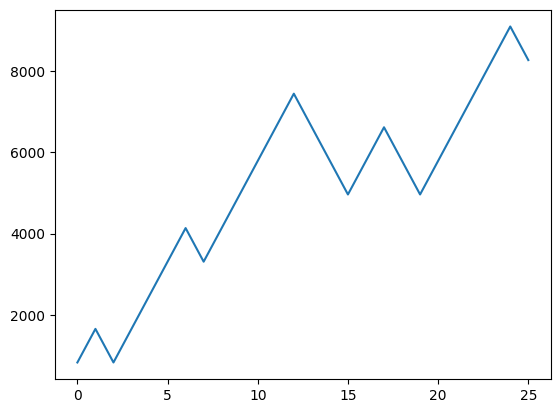

In [59]:
df = pd.read_csv('arp.csv')

tick = ticker
tick_Set = df[df['stock'] == tick] 
n = len(tick_Set)
print(f'Length: {n}')

date_array = []
for i in range(len(tick_Set)):
    date_array.append(tick_Set['date'].iloc[i][0:10])
    
tick_Set['NDs'] = date_array

changes = []
delta = timedelta(days = 1)
for i in range(len(tick_Set)):
    try:
        start = tick_Set['NDs'].values[i]
        s = date.fromisoformat(start)
        t = s + delta
        end = t.isoformat()
        p = yf.Ticker(tick).history(start = start, end = end)
        pct_change = ((p['Close'] - p['Open'])/p['Open']).values[0]
        if(pct_change >= 0.01):
            changes.append('Buy')
        elif(pct_change <= -0.01):
            changes.append('Sell')
        else:
            changes.append('Hold')
    except Exception as e:
        changes.append('Hold')

tick_Set['Change'] = changes

words = tick_Set['title']
sentiment = tick_Set['Change']
vectorizer = CountVectorizer(
    analyzer = 'word',
    lowercase = False,
)
features = vectorizer.fit_transform(words)
features_nd = features.toarray()
X_train, X_test, y_train, y_test  = train_test_split(
        features_nd, 
        sentiment,
        train_size=0.90, 
        random_state=1)

log_model = LogisticRegression(solver = 'saga', max_iter = 750,verbose = 0, warm_start = False, tol = 1e-6)
log_model = log_model.fit(X_train,y_train)

y_pred = log_model.predict(X_test)

pnl = []
profit = 0
n2 = len(y_test) - 1
probs = log_model.predict_proba(X_test)  

for i in range(n2):
    arg = np.argmax(probs[i])
    pro = probs[i][arg]
    da = tick_Set[tick_Set.index == y_test.index[i]]['NDs'].values[0]
    news = tick_Set[tick_Set.index == y_test.index[i]]['title'].values[0]
    s = date.fromisoformat(da)
    delta = timedelta(days = 1)
    t = s + delta
    end = t.isoformat()
    p = yf.Ticker(tick).history(start = start, end = end)
    if(pro > threshold):
        if(arg == 0):
            bias = 'Buy'
        elif(arg == 1):
            bias = 'Hold'
        else:
            bias = 'Sell'
    else:
        bias = 'Hold'
    if(bias == 'Buy'):
        profit += 10000*(p['Close'] - p['Open']).values[0]
        pnl.append(profit)
        print(Fore.GREEN + f'{news}: {bias}')
    elif(bias == 'Sell'):
        profit -= 10000*(p['Close'] - p['Open']).values[0]
        pnl.append(profit)
        print(Fore.RED + f'{news}: {bias}')
plt.plot(pnl)